# Processing Data

In [0]:
import scipy.stats as sts
import pystan
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/AhmedMinerva/MODERN-COMPUTATIONAL-STATISTICS/master/FP_weekly_in_situ_co2_mlo.csv", 
    skiprows=44, names=["Date", "CO2"])
print(data)

            Date     CO2
0     1958-03-29  316.19
1     1958-04-05  317.31
2     1958-04-12  317.69
3     1958-04-19  317.58
4     1958-04-26  316.48
...          ...     ...
3134  2019-08-31  409.32
3135  2019-09-07  408.80
3136  2019-09-14  408.61
3137  2019-09-21  408.50
3138  2019-09-28  408.28

[3139 rows x 2 columns]


In [3]:

data["Date"] = pd.to_datetime(data["Date"])

# Converting Dates to # of years passed since measurements started
data["Years"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days) / 365.25

# The exponential model converges when receiving data this way
data["Days"] = ((pd.to_datetime(data.Date) - pd.to_datetime(data.Date[0])).dt.days)

# Normalizing the time 
data["Normalized_Date"] = data["Days"] / max(data["Days"])
display(data.head())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,Date,CO2,Years,Days,Normalized_Date
0,1958-03-29,316.19,0.000000,0,0.000000
1,1958-04-05,317.31,0.019165,7,0.000312
2,1958-04-12,317.69,0.038330,14,0.000623
3,1958-04-19,317.58,0.057495,21,0.000935
4,1958-04-26,316.48,0.076660,28,0.001246


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


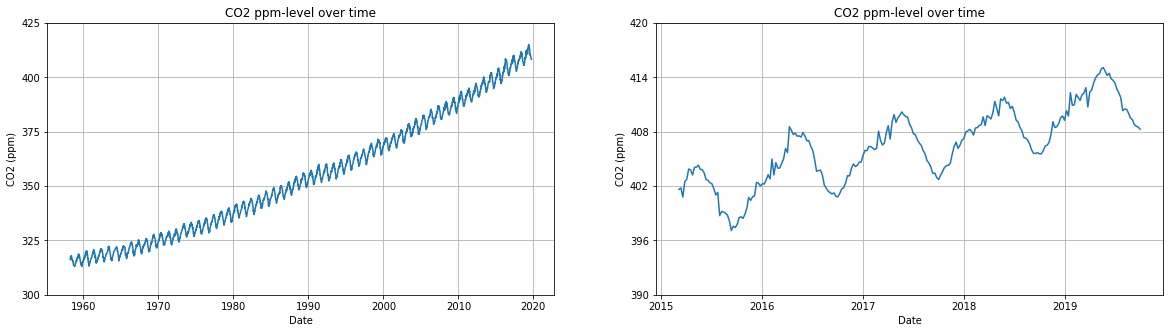

In [0]:
# Visualizing the entire data graph

fig = plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot(data["Date"],data["CO2"])
plt.grid()
plt.xlabel("Date")
plt.ylabel('CO2 (ppm)')
plt.title("CO2 ppm-level over time")
plt.yticks(np.linspace(300, 425, 6))

plt.subplot(1, 2, 2)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["CO2"]])
plt.grid()
plt.xlabel("Date")
plt.ylabel('CO2 (ppm)')
plt.title("CO2 ppm-level over time")
plt.yticks(np.linspace(390, 420, 6))

plt.show()

In [0]:
stan_data_Years = {
    "N" : 3139,
    "time" : data.Years.values,
    "CO2" : data.CO2.values
}

stan_data_Days = {
    "N" : 3139,
    "time" : data.Days.values,
    "CO2" : data.CO2.values
}

stan_data_Normalized = {
    "N" : 3139,
    "time" : data.Normalized_Date.values,
    "CO2" : data.CO2.values
}

In [0]:
#Compute the minimum of the co2 data to use as the prior for the y-intercept for the prior
print(min(data["CO2"]))

313.04


# Long-term Trend Models


In [12]:
linear_lg_trend_code = """
data {
    int<lower=0> N;             // length of data
    real<lower=0> time[N];      // time since start of measurement 1958-03-29
    real<lower=0> CO2[N];      // measured CO2
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(313, 10);
    c1 ~ normal(0, 1);
    noise ~ gamma(1, 0.5);
    
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*time[i], noise); 
    }
}

"""

quadratic_lg_trend_code = """
data {
    int<lower=0> N;             // length of data
    real<lower=0> time[N];      // time since start of measurement 1958-03-29
    real<lower=0> CO2[N];      // measured CO2
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(313, 15);
    c1 ~ normal(0, 1);
    noise ~ gamma(1, 0.5);
    
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*(time[i]^2), noise); 
    }
}

"""


polynomial_lg_trend_code="""
data {
    int<lower=0> N;             // length of data
    real<lower=0> time[N];      // time since start of measurement 1958-03-29
    real<lower=0> CO2[N];      // measured CO2
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> c2;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(313, 15);
    c1 ~ normal(0, 1);
    c2 ~ normal(0, 1);
    noise ~ inv_gamma(3, 2);
    
    for (i in 1:N) {
        CO2[i] ~ normal(c0 + c1*time[i] +c2*(time[i]^2), noise); 
    }
}

"""


exponantial_lg_trend_code = """
data {
    int<lower=0> N;             // length of data
    real<lower=0> time[N];      // time since start of measurement 1958-03-29
    real<lower=0> CO2[N];      // measured CO2
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(313, 15);
    c1 ~ normal(0, 1);
    noise ~ gamma(1, 0.5);
    
    for (i in 1:N) {
        CO2[i] ~ normal(c0*exp(c1*time[i]), noise);
    }
}

"""

logarithmic_lg_trend_code = """
data {
    int<lower=0> N;             // length of data
    real<lower=0> time[N];      // time since start of measurement 1958-03-29
    real<lower=0> CO2[N];      // measured CO2
}

parameters {
    real<lower=0> c0;                
    real<lower=0> c1;
    real<lower=0> noise;
}

model {
 
    // Priors
    c0 ~ normal(313, 15);
    c1 ~ normal(0, 1);
    noise ~ gamma(1, 0.5);
    
    for (i in 1:N) {
        CO2[i] ~ normal(c0*log(c1*time[i]), noise);
    }
}

"""

linear_model_trend = pystan.StanModel(model_code=linear_lg_trend_code)
quadratic_model_trend = pystan.StanModel(model_code=quadratic_lg_trend_code)
#quadratic_poly_model_trend = pystan.StanModel(model_code=polynomial_lg_trend_code)
#log_model_trend = pystan.StanModel(model_code=logarithmic_lg_trend_code)
exp_model_trend = pystan.StanModel(model_code=exponantial_lg_trend_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_00957da7180f42935400d1706fc29988 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ba186a895614f20a63e93abed4f3fd8f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0b2c76254f206d502912c586ebd5a625 NOW.


In [7]:
#Compile the model with different models
# linear_model_trend = pystan.StanModel(model_code=linear_lg_trend_code)
# quadratic_model_trend = pystan.StanModel(model_code=quadratic_lg_trend_code)
quadratic_poly_model_trend = pystan.StanModel(model_code=polynomial_lg_trend_code)
stan_results_qpoly = quadratic_poly_model_trend.sampling(data=stan_data_Days)
print(stan_results_qpoly)
# exp_model_trend = pystan.StanModel(model_code=exponantial_lg_trend_code)

#This log function function failed to converage
#log_model_trend = pystan.StanModel(model_code=logarithmic_lg_trend_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8c1cea466c7b978210915f72d085b098 NOW.


Inference for Stan model: anon_model_8c1cea466c7b978210915f72d085b098.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.58  3.0e-3   0.12 314.34 314.49 314.58 314.66 314.82   1704    1.0
c1    2.1e-3  6.6e-7 2.5e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1396    1.0
c2    9.7e-8 2.8e-11 1.1e-9 9.5e-8 9.7e-8 9.7e-8 9.8e-8 9.9e-8   1413    1.0
noise   2.25  7.3e-4   0.03   2.19   2.23   2.25   2.27   2.31   1507    1.0
lp__   -4134    0.04   1.38  -4138  -4135  -4134  -4133  -4133   1378    1.0

Samples were drawn using NUTS at Mon Dec 23 07:53:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Text(0, 0.5, 'CO2 (ppm)')

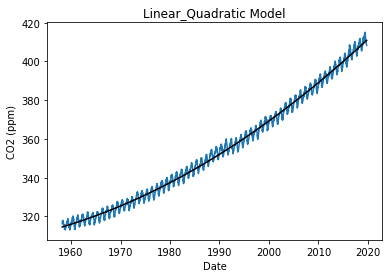

In [10]:
qpoly_samples = stan_results_qpoly.extract()
qpoly_data = qpoly_samples['c0'].mean() +qpoly_samples['c1'].mean()*data.Days.values +qpoly_samples['c2'].mean()*data.Days.values**2  

#plt.subplot(1, 4, 3)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, qpoly_data, color="black")
plt.title("Linear_Quadratic Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

In [0]:
# # Fitting stan model to the data. This will generate samples from the posterior over all parameters of the model.

stan_results_linear = linear_model_trend.sampling(data=stan_data_Days,iter=1000, n_jobs=3)
linear_samples = stan_results_linear.extract()

stan_results_quadratic = quadratic_model_trend.sampling(data=stan_data_Days,iter=1000, n_jobs=3)
quadratic_samples = stan_results_quadratic.extract()

stan_results_exp = exp_model_trend.sampling(data=stan_data_Normalized,iter=1000, n_jobs=3)
exp_samples = stan_results_exp.extract()

# stan_results_qpoly = quadratic_poly_model_trend.sampling(data=stan_data_Days)
# qpoly_samples = stan_results_qpoly.extract()
# # stan_results_log = log_model_trend.sampling(data=stan_data_Years)
# # log_samples = stan_results_log.extract()


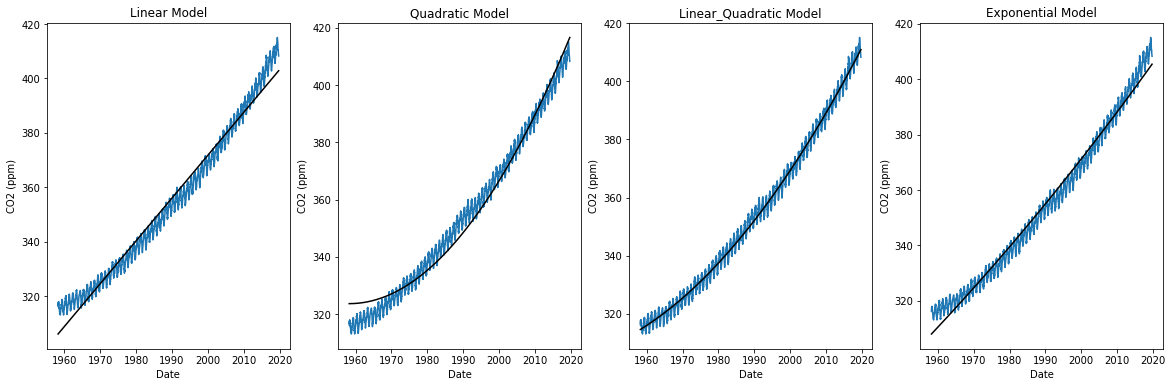

In [17]:
# Reproducing Figure 3
linear_data = linear_samples['c0'].mean() + linear_samples['c1'].mean()*data.Days.values
quadratic_data= quadratic_samples['c0'].mean() + quadratic_samples['c1'].mean()*data.Days.values**2  
exp_data = exp_samples['c0'].mean()*np.exp(exp_samples['c1'].mean()*data.Normalized_Date)
# qpoly_data = qpoly_samples['c0'].mean() +qpoly_samples['c1'].mean()*data.Days.values +qpoly_samples['c2'].mean()*data.Days.values**2  


fig1 = plt.figure(figsize=(20,6))

plt.subplot(1, 4, 1)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, linear_data, color="black")
plt.title("Linear Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

plt.subplot(1, 4, 2)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, quadratic_data, color="black")
plt.title("Quadratic Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

plt.subplot(1, 4, 3)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, qpoly_data, color="black")
plt.title("Linear_Quadratic Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

plt.subplot(1, 4, 4)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, exp_data, color="black")
plt.title("Exponential Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')
plt.show()


From the graph, we can see that Linear_Quadratic Trend is the best one to detrimine the behavior of the long trend of co2



---


# Seasonal variation Model

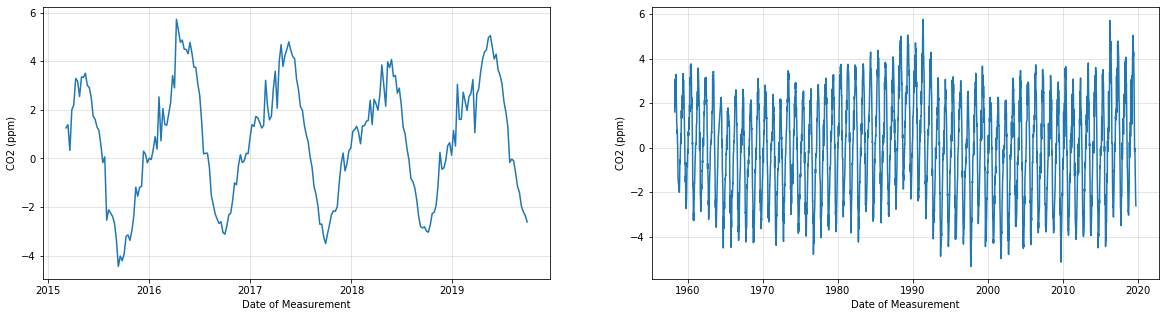

In [15]:
# Reproducing Figure 5

#the seasonal data is the orignal data - the long trend 
data["Seasonal"] = data.CO2 - qpoly_data

fig3 = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["Seasonal"]])
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel('CO2 (ppm)')
plt.subplot(1, 2, 2)
plt.plot(data.Date, data.Seasonal)
plt.grid(alpha=0.4)
plt.xlabel("Date of Measurement")
plt.ylabel('CO2 (ppm)')

plt.show()
#fig5.savefig("Figure5.png")

In [0]:
#data["Seasonal"] = data.CO2 - qpoly_data
stan_data_Days_season = {
    "N" : 3139,
    "time" : data.Days.values,
    "CO2" : data.Seasonal.values,
    "PI": 2*np.pi
}

stan_data_Years_season = {
    "N" : 3139,
    "time" : data.Years.values,
    "CO2" : data.Seasonal.values,
    "PI": 2*np.pi
}

In [0]:
quadratic_cosine = """
data {
 int<lower=1> N;
 real<lower=0> time[N];
 real CO2[N];
 

}
parameters {
 real<lower=0> c0;
 real<lower=0> c1;
 real<lower=0, upper=1> c2;

 real noise; 
}

model {

 // prior distributions
 c0 ~ cauchy(0, 1);
 c1 ~ cauchy(0, 1);
 c2 ~ cauchy(0, 1);
 noise ~ inv_gamma(3, 2);


 //Likelihood function:
 for(i in 1:N) 
 {
 CO2[i] ~ normal( (c0 * cos((2*pi()*time[i])/365.25 + c2)) +(c1 * cos((2*pi()*time[i])/365.25 + c2)), noise);

 }
}
"""


In [35]:
quadratic_cosine_model= pystan.StanModel(model_code=quadratic_cosine)
stan_results_quadratic_cosine = quadratic_cosine_model.sampling(data=stan_data_Days_season, iter=1000, n_jobs=3)
print(stan_results_quadratic_cosine)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b00ab355c15560e94b965ad5fa95441f NOW.


Inference for Stan model: anon_model_b00ab355c15560e94b965ad5fa95441f.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0      1.36    0.03   0.78   0.07   0.65    1.4   2.09   2.56    813    1.0
c1      1.26    0.03   0.78   0.05   0.53   1.23   1.97   2.55    819    1.0
c2    3.3e-4  9.8e-6 3.4e-4 7.3e-6 9.4e-5 2.1e-4 4.6e-4 1.3e-3   1226    1.0
noise   1.28  4.3e-4   0.01   1.25   1.27   1.28   1.29   1.31   1198    1.0
lp__   -2360    0.07   1.48  -2364  -2361  -2360  -2359  -2358    518    1.0

Samples were drawn using NUTS at Mon Dec 23 09:01:08 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [0]:
cosine_code = """
data {
 int<lower=1> N;
 real<lower=0> time[N];
 real CO2[N];
 

}
parameters {
 real<lower=0> c0;
 real<lower=0, upper=1> c1;
 real noise; 
}

model {

 // prior distributions
 c0 ~ cauchy(0, 1);
 c1 ~ cauchy(0, 1);
 noise ~ inv_gamma(3, 2);


 //Likelihood function:
 for(i in 1:N) 
 {
 CO2[i] ~ normal( (c0 * cos((2*pi()*time[i])/365.25 + c1)), noise);

 }
}
"""


In [49]:
cosine_model= pystan.StanModel(model_code=cosine_code)
stan_results_cosine = cosine_model.sampling(data=stan_data_Days_season, iter=1000, n_jobs=3)
print(stan_results_cosine)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74f7d7995ee6ab5a256011845d39c8f8 NOW.


Inference for Stan model: anon_model_74f7d7995ee6ab5a256011845d39c8f8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0      2.62  7.5e-4   0.03   2.55    2.6   2.62   2.64   2.68   1927    1.0
c1    3.3e-4  7.7e-6 3.4e-4 6.4e-6 9.2e-5 2.2e-4 4.6e-4 1.2e-3   1944    1.0
noise   1.28  3.9e-4   0.02   1.25   1.27   1.28   1.29   1.31   1778    1.0
lp__   -2359    0.05   1.34  -2363  -2360  -2359  -2358  -2358    720    1.0

Samples were drawn using NUTS at Mon Dec 23 09:30:34 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


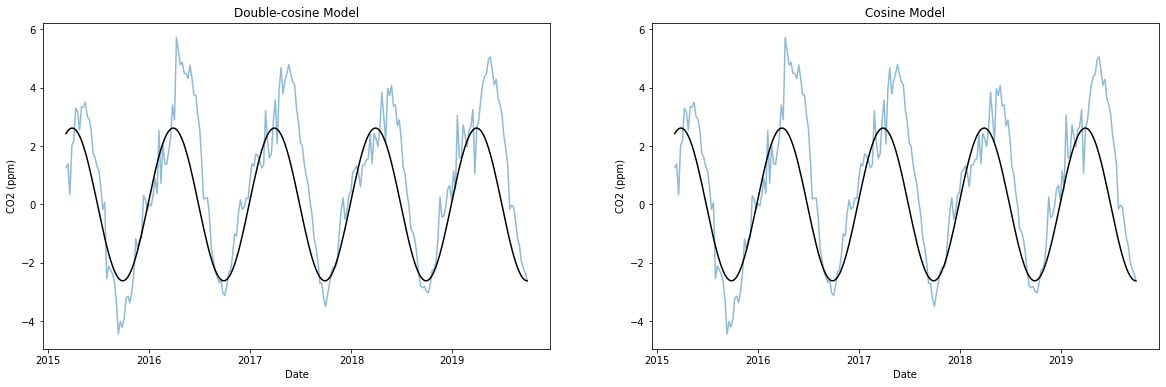

In [50]:
qcosine_samples = stan_results_quadratic_cosine.extract()
qcosine_data = (np.mean(qcosine_samples['c0']) * np.cos((2*np.pi*data.Days.values)/365.25 + np.mean(qcosine_samples['c2'])))+(np.mean(qcosine_samples['c1']) * np.cos((2*np.pi*data.Days.values)/365.25 + np.mean(qcosine_samples['c2'])))

cosine_samples = stan_results_cosine.extract()
cosine_data = (np.mean(cosine_samples['c0']) * np.cos((2*np.pi*data.Days.values)/365.25 + np.mean(cosine_samples['c1'])))

fig1 = plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["Seasonal"]],alpha=0.5)
plt.plot(data.loc[2900:, ["Date"]], qcosine_data[2900:], color="black")
plt.title("Double-cosine Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

plt.subplot(1, 2, 2)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["Seasonal"]],alpha=0.5)
plt.plot(data.loc[2900:, ["Date"]], cosine_data[2900:], color="black")
plt.title("Cosine Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')

plt.show()

In [52]:
#Calculating the Root Mean Square Error for both models to decide which one is better

cosine_rmse = np.sqrt(np.mean((data.Seasonal - cosine_data)**2))
qcosine_rmse = np.sqrt(np.mean((data.Seasonal - qcosine_data)**2))

print("The Root Mean Square Error for Cosine Model is:",cosine_rmse)
print("The Root Mean Square Error for Two_Cosine Model is:",qcosine_rmse)


The Root Mean Square Error for Cosine Model is: 1.280795325126505
The Root Mean Square Error for Two_Cosine Model is: 1.280798021286471


In [0]:
linear_data = linear_samples['c0'].mean() + linear_samples['c1'].mean()*data.Days.values
quadratic_data= quadratic_samples['c0'].mean() + quadratic_samples['c1'].mean()*data.Days.values**2  
exp_data = exp_samples['c0'].mean()*np.exp(exp_samples['c1'].mean()*data.Normalized_Date)
# qpoly_data = qpoly_samples['c0'].mean() +qpoly_samples['c1'].mean()*data.Days.values +qpoly_samples['c2'].mean()*data.Days.values**2  


fig1 = plt.figure(figsize=(20,6))

plt.subplot(1, 4, 1)
plt.plot(data.Date, data.CO2)
plt.plot(data.Date, linear_data, color="black")
plt.title("Linear Model")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')



---


# Full Model

In [0]:
stan_data_Years = {
    "N" : 3139,
    "time" : data.Years.values,
    "CO2" : data.CO2.values
}

In [0]:
full_stan = """
data {
 int<lower=1> N;
 real<lower=0> time[N];
 real<lower=0> CO2[N];
 

}
parameters {
 real<lower=0> c0;
 real<lower=0> c1;
 real<lower=0> c2;
 real<lower=0> c3;
 real<lower=0, upper=1> c4;
 real noise; 
}

model {

 // prior distributions
 c0 ~ cauchy(0, 1);
 c1 ~ cauchy(0, 1);
 c2 ~ cauchy(0, 1);
 c3 ~ cauchy(0, 1);
 c4 ~ cauchy(0, 1);
 noise ~ inv_gamma(3, 2);


 //Likelihood function:
 for(i in 1:N) 
 {
 CO2[i] ~ normal( c0+c1*time[i]+ c2*(time[i])^2 +(c3 * cos((2*pi()*time[i]) + c4)), noise);

 }
}
"""


In [60]:
stan_model = pystan.StanModel(model_code=full_stan)
results_model= stan_model.sampling(data=stan_data_Years,iter=2000, n_jobs=3)
print(results_model.stansummary())
samples = results_model.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_68a4a123f2ccf66d9ba7540212db6722 NOW.


Inference for Stan model: anon_model_68a4a123f2ccf66d9ba7540212db6722.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.59  2.1e-3   0.07 314.44 314.54 314.59 314.64 314.72   1138   1.01
c1      0.77  1.8e-4 5.4e-3   0.76   0.76   0.77   0.77   0.78    927   1.01
c2      0.01  2.7e-6 8.4e-5   0.01   0.01   0.01   0.01   0.01    955   1.01
c3      2.62  4.7e-4   0.03   2.55    2.6   2.62   2.64   2.68   4601    1.0
c4    3.5e-4  1.2e-5 3.5e-4 1.1e-5 1.0e-4 2.5e-4 4.8e-4 1.3e-3    816   1.01
noise   1.28  2.8e-4   0.02   1.25   1.27   1.28   1.29   1.32   3583    1.0
lp__   -2371    0.05   1.77  -2376  -2372  -2371  -2370  -2369   1158   1.01

Samples were drawn using NUTS at Mon Dec 23 12:00:48 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains

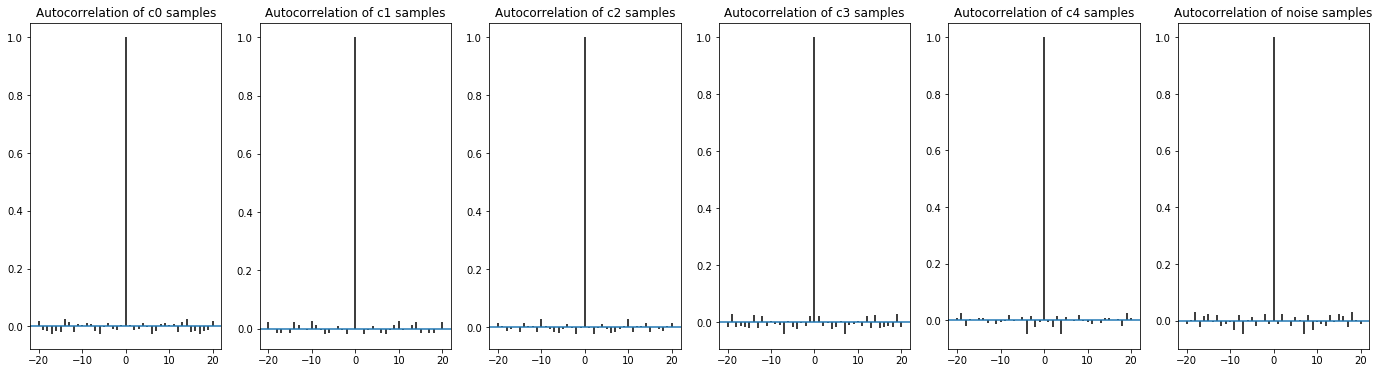

In [65]:
parameters=['c0', 'c1', 'c2', 'c3', 'c4', 'noise']
# Plot sample autocorrelation for each parameter.

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal    
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

plt.figure(figsize=(24, 6))
for i in range(len(parameters)):
    plt.subplot(1, 6, i+1)
    plot_acf(samples[parameters[i]])
    plt.title(f'Autocorrelation of {parameters[i]} samples')

plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


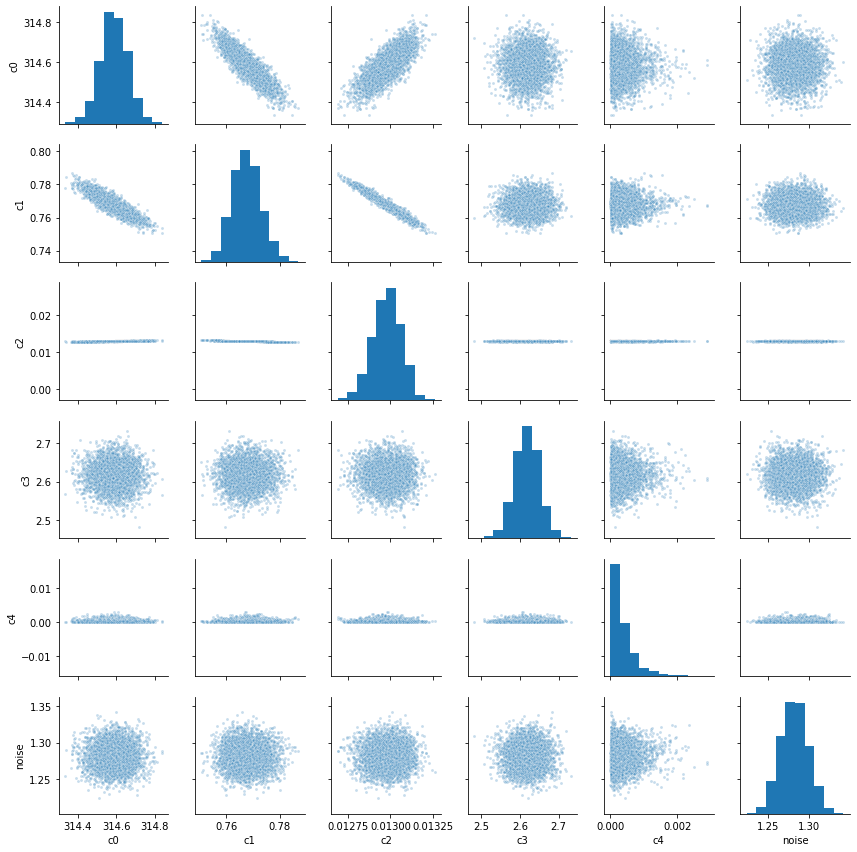

In [69]:
# Make pair plot of the posteriors over all parameters of the model.
import seaborn
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, size=2, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

In [0]:
def sample_mean(samples, dates):

  dates = np.array(dates)
  return sts.norm.rvs(np.mean(samples['c0'])+np.mean(samples['c1'])*dates+ np.mean(samples['c2'])*(dates**2) +(np.mean(samples['c3']) * np.cos((2*np.pi*dates) + np.mean(samples['c4']))),np.mean(samples['noise']))


In [0]:
realmodel = sample_mean(samples, data.Years.values)

In [124]:
#print(np.shape(realmodel))

(3139,)


In [89]:
# realmodel_upper= np.percentile(realmodel, q=97.5)
# realmodel_down=np.percentile(realmodel, q=2.5)

407.7608810150848


In [0]:
def sample_percentile(samples, dates, value):
  dates = np.array(dates)
  return sts.norm.rvs(np.percentile(samples['c0'], value)+np.percentile(samples['c1'],value)*dates +np.percentile(samples['c2'],value)*(dates**2)+(np.percentile(samples['c3'], value)) * np.cos((2*np.pi*dates) + np.percentile(samples['c4'], value)),np.percentile(samples['noise'], value))

In [0]:
realmodel_upper=sample_percentile(samples,data.Years.values,97.5)
realmodel_lower=sample_percentile(samples,data.Years.values,2.5)

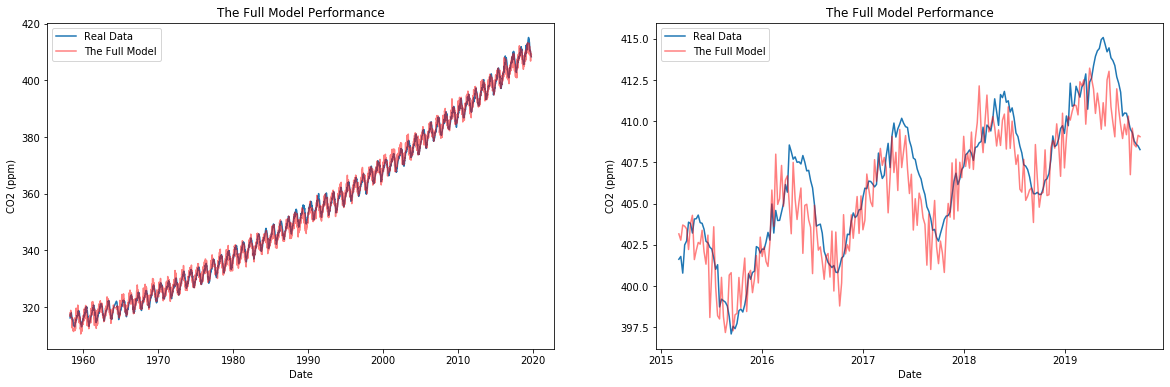

In [98]:
fig1 = plt.figure(figsize=(20,6))


plt.subplot(1, 2, 1)
plt.plot(data.Date.values, data['CO2'], label="Real Data", alpha=1)
plt.plot(data.Date.values, realmodel, label="The Full Model", color='red',alpha=0.5)
plt.xlabel('Date')
plt.ylabel("CO2 (ppm)")
plt.title("The Full Model Performance")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["CO2"]],label="Real Data",alpha=1)
plt.plot(data.loc[2900:, ["Date"]], realmodel[2900:], color="red",label="The Full Model",alpha=0.5)
plt.title("The Full Model Performance")
plt.xlabel("Date")
plt.ylabel(r'CO2 (ppm)')
plt.legend()
plt.show()

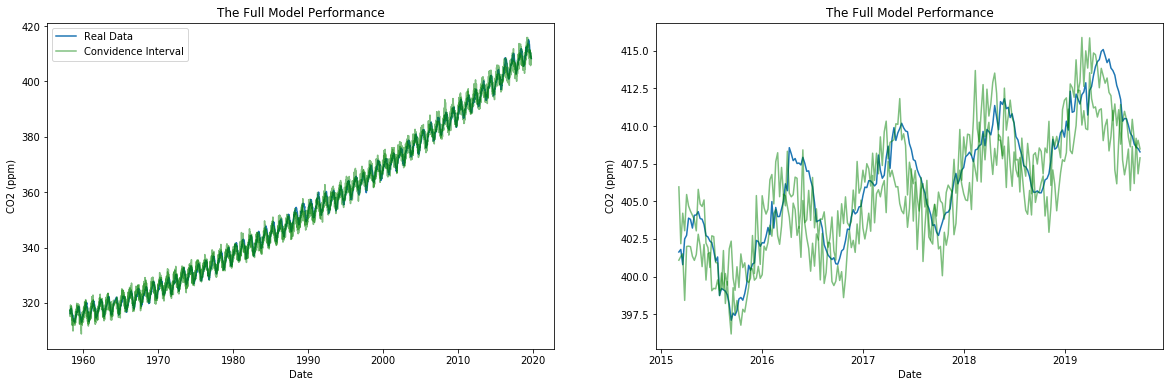

In [96]:
# fig1 = plt.figure(figsize=(20,6))


# plt.subplot(1, 2, 1)
# plt.plot(data.Date.values, data['CO2'], label="Real Data", alpha=1)
# plt.plot(data.Date.values, realmodel_upper, label="Convidence Interval", color='green',alpha=0.5)
# plt.plot(data.Date.values, realmodel_lower, color='green',alpha=0.5)
# plt.xlabel('Date')
# plt.ylabel("CO2 (ppm)")
# plt.title("The Full Model Performance")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(data.loc[2900:, ["Date"]], data.loc[2900:, ["CO2"]],alpha=1)
# plt.plot(data.loc[2900:, ["Date"]], realmodel_upper[2900:], label="Convidence Interval", color="green",alpha=0.5)
# plt.plot(data.loc[2900:, ["Date"]], realmodel_lower[2900:], color="green",alpha=0.5)

# plt.title("The Full Model Performance")
# plt.xlabel("Date")
# plt.ylabel(r'CO2 (ppm)')

# plt.show()

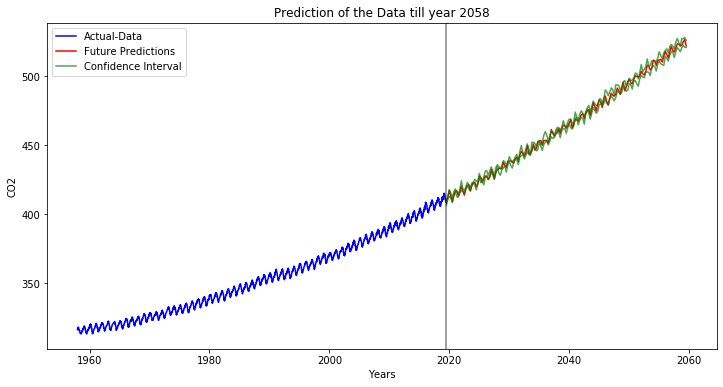

In [114]:
#Future Prediction:
#From the last year in the data till 2058

abs_Years = [data.Years.values[-1]]
act_years=[data.Years.values[-1]+1958]

#for every year, I have sampled 4 point to have enough data and represent my predictions well
for i in range(40*4):
  abs_Years.append(abs_Years[-1]+0.25)
  act_years.append(act_years[-1]+0.25)

old_years=[]
for i in data.Years.values:
  old_years.append(i+1958)


prediction = sample_mean(samples, abs_Years)
upper_prediction=sample_percentile(samples,abs_Years,97.5)
lower_prediction=sample_percentile(samples,abs_Years,2.5,)

plt.figure(figsize = (12,6))
plt.plot(old_years, data['CO2'], color = 'blue',label = 'Actual-Data')
plt.plot(act_years, prediction, color = 'red', label = 'Future Predictions')
plt.plot(act_years, upper_prediction, color = 'green',alpha=0.7, label = 'Confidence Interval')
plt.plot(act_years, lower_prediction, color = 'green',alpha=0.7)


plt.legend()
plt.title("Prediction of the Data till year 2058")
plt.xlabel("Years")
plt.ylabel("CO2")
plt.axvline(old_years[-1], color='black',alpha=0.5)
#plt.axhline(450, color='black', alpha=0.5)
plt.show()


In [115]:
print("Predicted CO2 ppm Levels 40 years from now: ", prediction[-1])
print("95% Confidence Intervals: ", lower_prediction[-1], upper_prediction[-1])

Predicted CO2 ppm Levels 40 years from now:  521.894082873875
95% Confidence Intervals:  520.7607356933029 525.8507901991501


In [121]:
print("Years when there is a strong probabiltuy for 450 ppm:", act_years[np.min(np.argwhere(lower_prediction > 450))], act_years[np.min(np.argwhere(upper_prediction > 450))] )


Years when there is a strong probabiltuy for 450 ppm: 2035.0003422313484 2033.0003422313484


#Shortcoming and statistical differences:

In [128]:
replicated_data=[]
t=np.array(data.Years.values)
for i in range(1000):
  replicated_data.append(sts.norm.rvs(samples['c0'][i]+samples['c1'][i]*t+samples['c2'][i]*(t**2)+samples['c3'][i]* np.cos((2*np.pi*t) + samples['c4'][i]),samples['noise'][i]))

  #sts.norm.rvs(np.mean(samples['c0'])+np.mean(samples['c1'])*dates+ np.mean(samples['c2'])*(dates**2) +(np.mean(samples['c3']) * np.cos((2*np.pi*dates) + np.mean(samples['c4']))),np.mean(samples['noise']))
print(np.shape(replicated_data))

(1000, 3139)


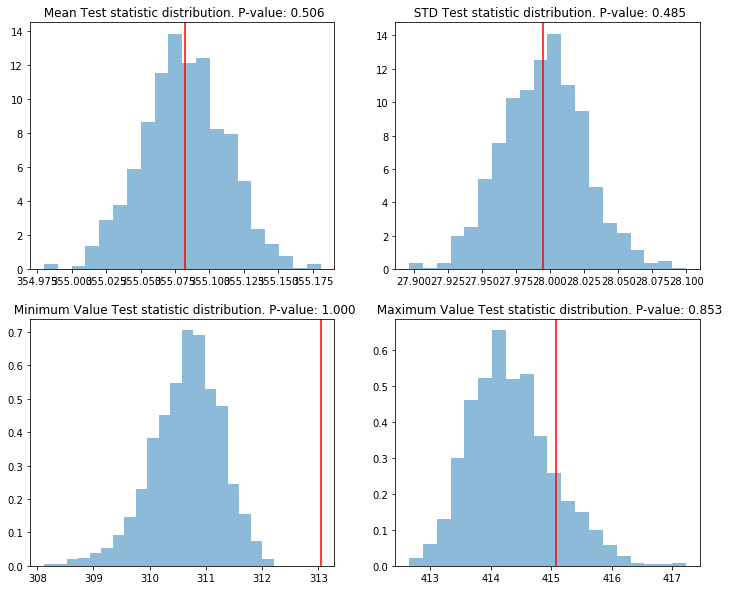

In [156]:
plt.figure(figsize=(12,10))
plt.subplot(2, 2, 1)

replicated_statistic = np.mean(replicated_data, axis=1)
real_statistic = np.mean(data.CO2.values)
plt.hist(replicated_statistic, bins=20, alpha=0.5, density=True)
plt.axvline(real_statistic, color='red')
plt.title(' Mean Test statistic distribution. P-value: %.3f' % (np.mean(np.array(replicated_statistic) <= real_statistic)))    

plt.subplot(2, 2, 2)

replicated_statistic = np.std(replicated_data, axis=1)
real_statistic = np.std(data.CO2.values)
plt.hist(replicated_statistic, bins=20, alpha=0.5, density=True)
plt.axvline(real_statistic, color='red')
plt.title(' STD Test statistic distribution. P-value: %.3f' % (np.mean(np.array(replicated_statistic) <= real_statistic)))

plt.subplot(2, 2, 3)
replicated_statistic = np.min(replicated_data, axis=1)
real_statistic = np.min(data.CO2.values)
plt.hist(replicated_statistic, bins=20, alpha=0.5, density=True)
plt.axvline(real_statistic, color='red')
plt.title(' Minimum Value Test statistic distribution. P-value: %.3f' % (np.mean(np.array(replicated_statistic) <= real_statistic)))    

plt.subplot(2, 2, 4)

replicated_statistic = np.max(replicated_data, axis=1)
real_statistic = np.max(data.CO2.values)
plt.hist(replicated_statistic, bins=20, alpha=0.5, density=True)
plt.axvline(real_statistic, color='red')
plt.title(' Maximum Value Test statistic distribution. P-value: %.3f' % (np.mean(np.array(replicated_statistic) <= real_statistic)))
plt.show()